# QOSF Mentorship Program Screening Tasks

## Task 2 Noise, Noise, and More Noise

One of the main challenges in quantum computing is the noise in current devices. In this task, you will create a simple noise generator and assess its effect. You can use any framework you like (Qiskit, Cirq, etc..)

### 1. Noise Model
A standard way to represent the noise in a quantum circuit is through Pauli operators $(\sigma_x, \sigma_y, \sigma_z)$. Build a function with input $\alpha$, $ \beta $ and `QuantumCircuit` where:
- $\alpha \to$ Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
- $\beta \to$ Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
- `QuantumCircuit` $\to$ where the noise will be added

The output should be the Quantum Circuit with Noise 

Import Necessary Modules:

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline
import random

Define the Noise Function:

In [31]:
def add_pauli_noise(a, b, circuit):
    noisy_circuit = circuit.copy()
    paulis = ['x', 'y', 'z']
    
    for idx, instr in enumerate(circuit.data):
        # gate = instr.operation.name
        # qubits = instr.qubits
        gate = instr[0].name
        qubits = instr[1]
        if gate in ['cx', 'cz', 'swap', 'ccx']:  # Two-qubit gates
            prob = b
        elif len(qubits) == 1:  # One-qubit gates
            prob = a
        else:
            prob = 0  # For other cases, no noise
        
        if random.random() < prob:
            # Choose a random Pauli operator
            pauli = random.choice(paulis)
            q = qubits[0]
            noisy_circuit.rx(random.uniform(0, 2*3.1415), q)  # Example modification
            # Alternatively, use the actual Pauli gates
            if pauli == 'x':
                noisy_circuit.x(q)
            elif pauli == 'y':
                noisy_circuit.y(q)
            elif pauli == 'z':
                noisy_circuit.z(q)
    
    return noisy_circuit

In [57]:
# Create a sample circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Add noise
noisy_qc = add_pauli_noise(a=0.1, b=0.2, circuit=qc)
print(noisy_qc)

        ┌───┐      ░ ┌─┐┌────────────┐┌───┐
   q_0: ┤ H ├──■───░─┤M├┤ Rx(4.0901) ├┤ X ├
        └───┘┌─┴─┐ ░ └╥┘└────┬─┬─────┘└───┘
   q_1: ─────┤ X ├─░──╫──────┤M├───────────
             └───┘ ░  ║      └╥┘           
meas: 2/══════════════╩═══════╩════════════
                      0       1            


C:\Users\user\AppData\Local\Temp\ipykernel_35984\1529138821.py:8: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  gate = instr[0].name
C:\Users\user\AppData\Local\Temp\ipykernel_35984\1529138821.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  qubits = instr[1]


### 2. Gate Basis
Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: `{CX,ID,RZ,SX,X}`

In [3]:
def transform_to_basis(qc):
    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    pass_manager = PassManager(BasisTranslator(SessionEquivalenceLibrary, basis_gates))
    transformed_circuit = pass_manager.run(qc)
    return transformed_circuit

### 3. Adding two numbers with a quantum computer
Build a function (`quantum_sum`) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.

In [4]:
# def qft(n):
#     """Create a quantum circuit implementing the QFT over n qubits."""
#     qc = QuantumCircuit(n)
#     for j in range(n):
#         # Apply the Hadamard gate
#         qc.h(j)
#         # Apply controlled phase rotations
#         for k in range(j+1, n):
#             angle = np.pi / (2**(k - j))
#             qc.cp(angle, k, j)
#         # Swap qubits to reverse the order
#     # Swap qubits to reverse the order
#     for i in range(n//2):
#         qc.swap(i, n-i-1)
#     return qc

def qft(circuit, qubits):
    """Apply the QFT on the specified qubits in the circuit."""
    n = len(qubits)
    for j in range(n):
        circuit.h(qubits[j])
        for k in range(j+1, n):
            angle = np.pi / 2**(k - j)
            circuit.cp(angle, qubits[k], qubits[j])
    # Include SWAP gates to reverse the qubit order
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])

In [5]:
# def inverse_qft(n):
#     """Create a quantum circuit implementing the inverse QFT over n qubits."""
#     qc = QuantumCircuit(n)
#     # Apply the inverse QFT operations
#     for j in reversed(range(n)):
#         # Swap qubits to reverse the order
#         for i in range(n//2):
#             qc.swap(i, n-i-1)
#         # Apply controlled phase rotations
#         for k in range(j+1, n):
#             angle = -np.pi / (2**(k - j))
#             qc.cp(angle, k, j)
#         # Apply the Hadamard gate
#         qc.h(j)
#     return qc

def inverse_qft(circuit, qubits):
    """Apply the inverse QFT on the specified qubits in the circuit."""
    n = len(qubits)
    # Include SWAP gates to reverse the qubit order
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])
    for j in reversed(range(n)):
        for k in range(j+1, n):
            angle = -np.pi / 2**(k - j)
            circuit.cp(angle, qubits[k], qubits[j])
        circuit.h(qubits[j])

In [6]:
def quantum_sum(a, b, n):
    qr_a = QuantumRegister(n, name='a')  # Register to store 'a' and the result
    qr_b = QuantumRegister(n, name='b')  # Register to store 'b'
    cr = ClassicalRegister(n, name='result')  # Classical register for measurement
    
    qc = QuantumCircuit(qr_a, qr_b, cr)
    
    # Initialize the qubits with the binary representation of the numbers
    # for i in range(n):
    #     if (a >> i) & 1:
    #         qc.x(i)
    #     if (b >> i) & 1:
    #         qc.x(i + n)

    # Initialize Register A with the value 'a'
    a_binary = format(a, f'0{n}b')
    for idx, bit in enumerate(reversed(a_binary)):
        if bit == '1':
            qc.x(qr_a[idx])

    # Initialize Register B with the value 'b'
    b_binary = format(b, f'0{n}b')
    for idx, bit in enumerate(reversed(b_binary)):
        if bit == '1':
            qc.x(qr_b[idx])
    
    # Apply QFT to Register A
    qft(qc, qr_a)
    
    # Apply controlled phase shifts based on Register B
    for i in range(n):          # Loop over qubits in Register B
        for j in range(n):      # Loop over qubits in Register A
            if i <= j:
                angle = (2 * np.pi) / (2 ** (j - i + 1))
                qc.cp(angle, qr_b[i], qr_a[j])

    # Apply inverse QFT to Register A
    inverse_qft(qc, qr_a)

    # Measure Register A to get the result
    qc.measure(qr_a, cr)
    
    return qc

### 4. Effects of noise on quantum addition
Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 
- How does the noise affect the results?
- Is there a way to decrease the effect of noise?
- How does the number of gates used affect the results?

In [8]:
def analyze_quantum_addition(a, b, num_a, num_b, n):
    qc = quantum_sum(num_a, num_b, n)
    transformed_qc = transform_to_basis(qc)
    noisy_qc = add_pauli_noise(a, b, transformed_qc)
    
    # Simulate the circuit with noise
    simulator = AerSimulator()
    transpiled_qc = transpile(noisy_qc, simulator)
    result = simulator.run(transpiled_qc, shots=1024).result()
    counts = result.get_counts(0)
    
    return counts

In [45]:
qc = quantum_sum(3,5,4)
transform_to_basis(qc)
# add_pauli_noise(1, 0, transformed_qc).draw()

global phase: 4.8106
             ┌───┐    ┌─────────┐┌────┐┌─────────┐┌───┐┌──────────┐┌───┐»
     a_0: ───┤ X ├────┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-π/4) ├┤ X ├»
             ├───┤    ├─────────┤└────┘└─────────┘└─┬─┘└──────────┘└─┬─┘»
     a_1: ───┤ X ├────┤ Rz(π/4) ├───────────────────■────────────────■──»
          ┌──┴───┴──┐ └─────────┘                                       »
     a_2: ┤ Rz(π/8) ├───────────────────────────────────────────────────»
          ├─────────┴┐                                                  »
     a_3: ┤ Rz(π/16) ├──────────────────────────────────────────────────»
          └──┬───┬───┘┌─────────┐                                       »
     b_0: ───┤ X ├────┤ Rz(π/2) ├───────────────────────────────────────»
          ┌──┴───┴──┐ └─────────┘                                       »
     b_1: ┤ Rz(π/2) ├───────────────────────────────────────────────────»
          └──┬───┬──┘ ┌─────────┐                                       »
     b_2: ───┤ X ├────┤ Rz(π/2) ├───────────────────────────────────────»
          ┌──┴───┴──┐ └─────────┘                                       »
     b_3: ┤ Rz(π/2) ├───────────────────────────────────────────────────»
          └─────────┘                                                   »
result: 4/══════════════════════════════════════════════════════════════»
                                                                        »
«          ┌─────────┐      ┌───┐┌──────────┐┌───┐┌─────────┐     ┌───┐»
«     a_0: ┤ Rz(π/4) ├──────┤ X ├┤ Rz(-π/8) ├┤ X ├┤ Rz(π/8) ├─────┤ X ├»
«          ├─────────┤┌────┐└─┬─┘├─────────┬┘└─┬─┘└─────────┘┌───┐└─┬─┘»
«     a_1: ┤ Rz(π/2) ├┤ √X ├──┼──┤ Rz(π/2) ├───┼─────────────┤ X ├──┼──»
«          └─────────┘└────┘  │  └─────────┘   │  ┌─────────┐└─┬─┘  │  »
«     a_2: ───────────────────■────────────────■──┤ Rz(π/4) ├──■────┼──»
«                                                 └─────────┘       │  »
«     a_3: ─────────────────────────────────────────────────────────■──»
«                                                                      »
«     b_0: ────────────────────────────────────────────────────────────»
«                                                                      »
«     b_1: ────────────────────────────────────────────────────────────»
«                                                                      »
«     b_2: ────────────────────────────────────────────────────────────»
«                                                                      »
«     b_3: ────────────────────────────────────────────────────────────»
«                                                                      »
«result: 4/════════════════════════════════════════════════════════════»
«                                                                      »
«          ┌───────────┐     ┌───┐┌──────────┐                            »
«     a_0: ┤ Rz(-π/16) ├─────┤ X ├┤ Rz(π/16) ├────────────────────────────»
«          └┬──────────┤┌───┐└─┬─┘├─────────┬┘      ┌───┐┌──────────┐┌───┐»
«     a_1: ─┤ Rz(-π/4) ├┤ X ├──┼──┤ Rz(π/4) ├───────┤ X ├┤ Rz(-π/8) ├┤ X ├»
«           └──────────┘└─┬─┘  │  ├─────────┤ ┌────┐└─┬─┘├─────────┬┘└─┬─┘»
«     a_2: ───────────────■────┼──┤ Rz(π/2) ├─┤ √X ├──┼──┤ Rz(π/2) ├───┼──»
«                              │  ├─────────┤ └────┘  │  └─────────┘   │  »
«     a_3: ────────────────────■──┤ Rz(π/8) ├─────────■────────────────■──»
«                                 └─────────┘                             »
«     b_0: ───────────────────────────────────────────────────────────────»
«                                                                         »
«     b_1: ───────────────────────────────────────────────────────────────»
«                                                                         »
«     b_2: ───────────────────────────────────────────────────────────────»
«                                                                         »
«     b_3: ───────────────────────────────────

Noise levels: a=0.5, b=0.5
{'1000': 1024}


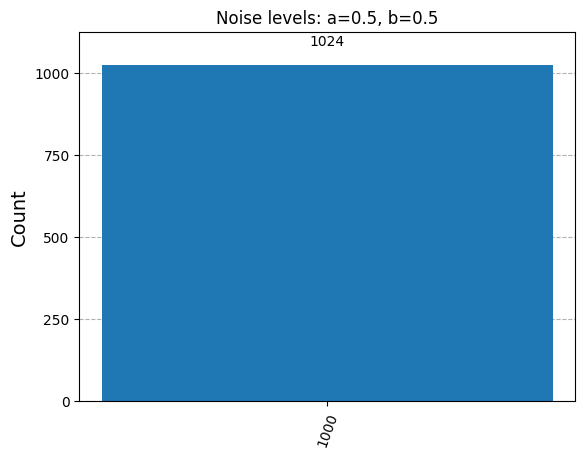

In [28]:
a_values = [0.5]#, 0.1, 0.2, 0.3]
b_values = [0.5]#, 0.1, 0.2, 0.3]
num_a = 3
num_b = 5
n = 4  # Number of qubits to represent the numbers

for a in a_values:
    for b in b_values:
        counts = analyze_quantum_addition(a, b, num_a, num_b, n)
        print(f"Noise levels: a={a}, b={b}")
        print(counts)

        # Plot the histogram
        plot_histogram(counts, title=f"Noise levels: a={a}, b={b}")
        plt.show()